In [1]:

import seaborn as sns
import matplotlib.pyplot as plt



import os


# Limit the number of cores used by OpenMP
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"
import numpy as np
np.random.seed(49)
import pandas as pd

from helper_simulation import *
from helper_util import *
from comparison import ComparisonGong, ComparisonBodik

from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests import ParCorr
from tigramite import plotting as tp



from rpy2.robjects.conversion import localconverter


from scipy.stats import t as t_distribution
from rpy2.robjects.conversion import localconverter
import matplotlib.pyplot as plt
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")    

%matplotlib inline



max_id=get_max("exp_result")
exp_str=""
log_path=f"exp_result/{str(max_id)}.{current_date}.simulationComparisonSingleTailVersion"

logger=get_logger(log_path)


/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


exp_result/114.20250226.simulationComparisonSingleTailVersion/xx.log


In [6]:
num_nodes = 7  # number of nodes
n=5000 # number of samples
sparsity=0.3
quantile=1 
pc_alpha=0.005

adjacency_matrix,edges_matrix = generate_dag(num_nodes,edge_probability=sparsity)

## This block generates a Directed Acyclic Graph (DAG) and simulates data based on it. Then, it performs causal inference on the generated data using two different methods (the method from this paper and Gong's method) and compares the error rates of the inferred results with the true graph. Finally, it plots the true graph and the inferred results from both methods.


In [7]:


pathh=os.path.join(log_path,f"NodeSize:{num_nodes},EdgeSize:{(adjacency_matrix>0).sum()}.pdf")
IC_1=np.linalg.inv(np.eye(adjacency_matrix.shape[0])-adjacency_matrix)

### PART 1: non-timeseries version (cross-sectional data)

the ground truth graph is:


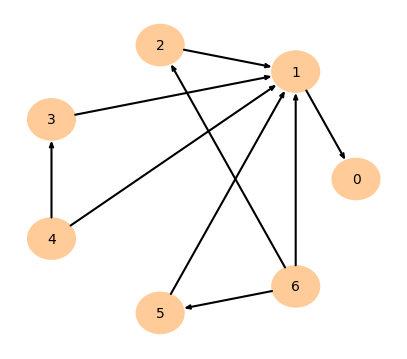

the results of this paper is: (with error rate: 12.5%)


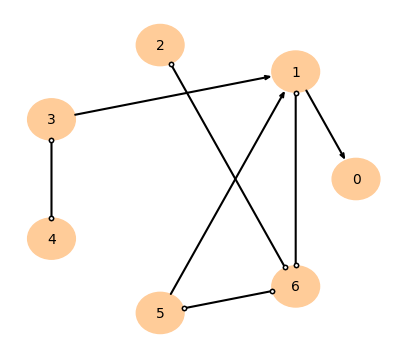

the results of Gong is: (with error rate: 38.5%)


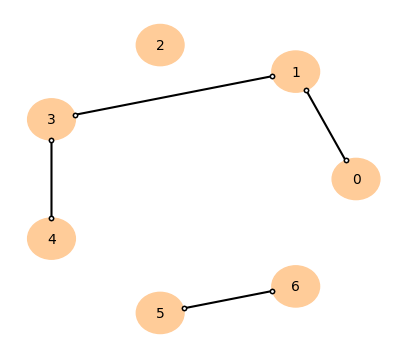

In [8]:




pathh=os.path.join(log_path,f"NodeSize:{num_nodes},EdgeSize:{(adjacency_matrix>0).sum()}.pdf")


IC_1=np.linalg.inv(np.eye(adjacency_matrix.shape[0])-adjacency_matrix)
N_data=simulation(n,num_nodes).T
X_data=otimes(IC_1,N_data,False)
data_df=pd.DataFrame(X_data.T)


resultsThisPaper,_=method_this_paper(data_df,pc_alpha=pc_alpha,quantile=quantile)
resultsGong=ComparisonGong(data_df,alpha = 0.04, beta = 1.26)

error_rate_this_paper,_=compare_graphs(resultsThisPaper,edges_matrix)
error_rate_gong,_=compare_graphs(resultsGong,edges_matrix)
print("the ground truth graph is:")
        
        

draw_graph(edges_matrix,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))
print("the results of this paper is: (with error rate: {:.1f}%)".format(error_rate_this_paper*100))
draw_graph(resultsThisPaper,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))
print("the results of Gong is: (with error rate: {:.1f}%)".format(error_rate_gong*100))
draw_graph(resultsGong,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))

## have a lot of scatter plot to visualize the pairwise relationships


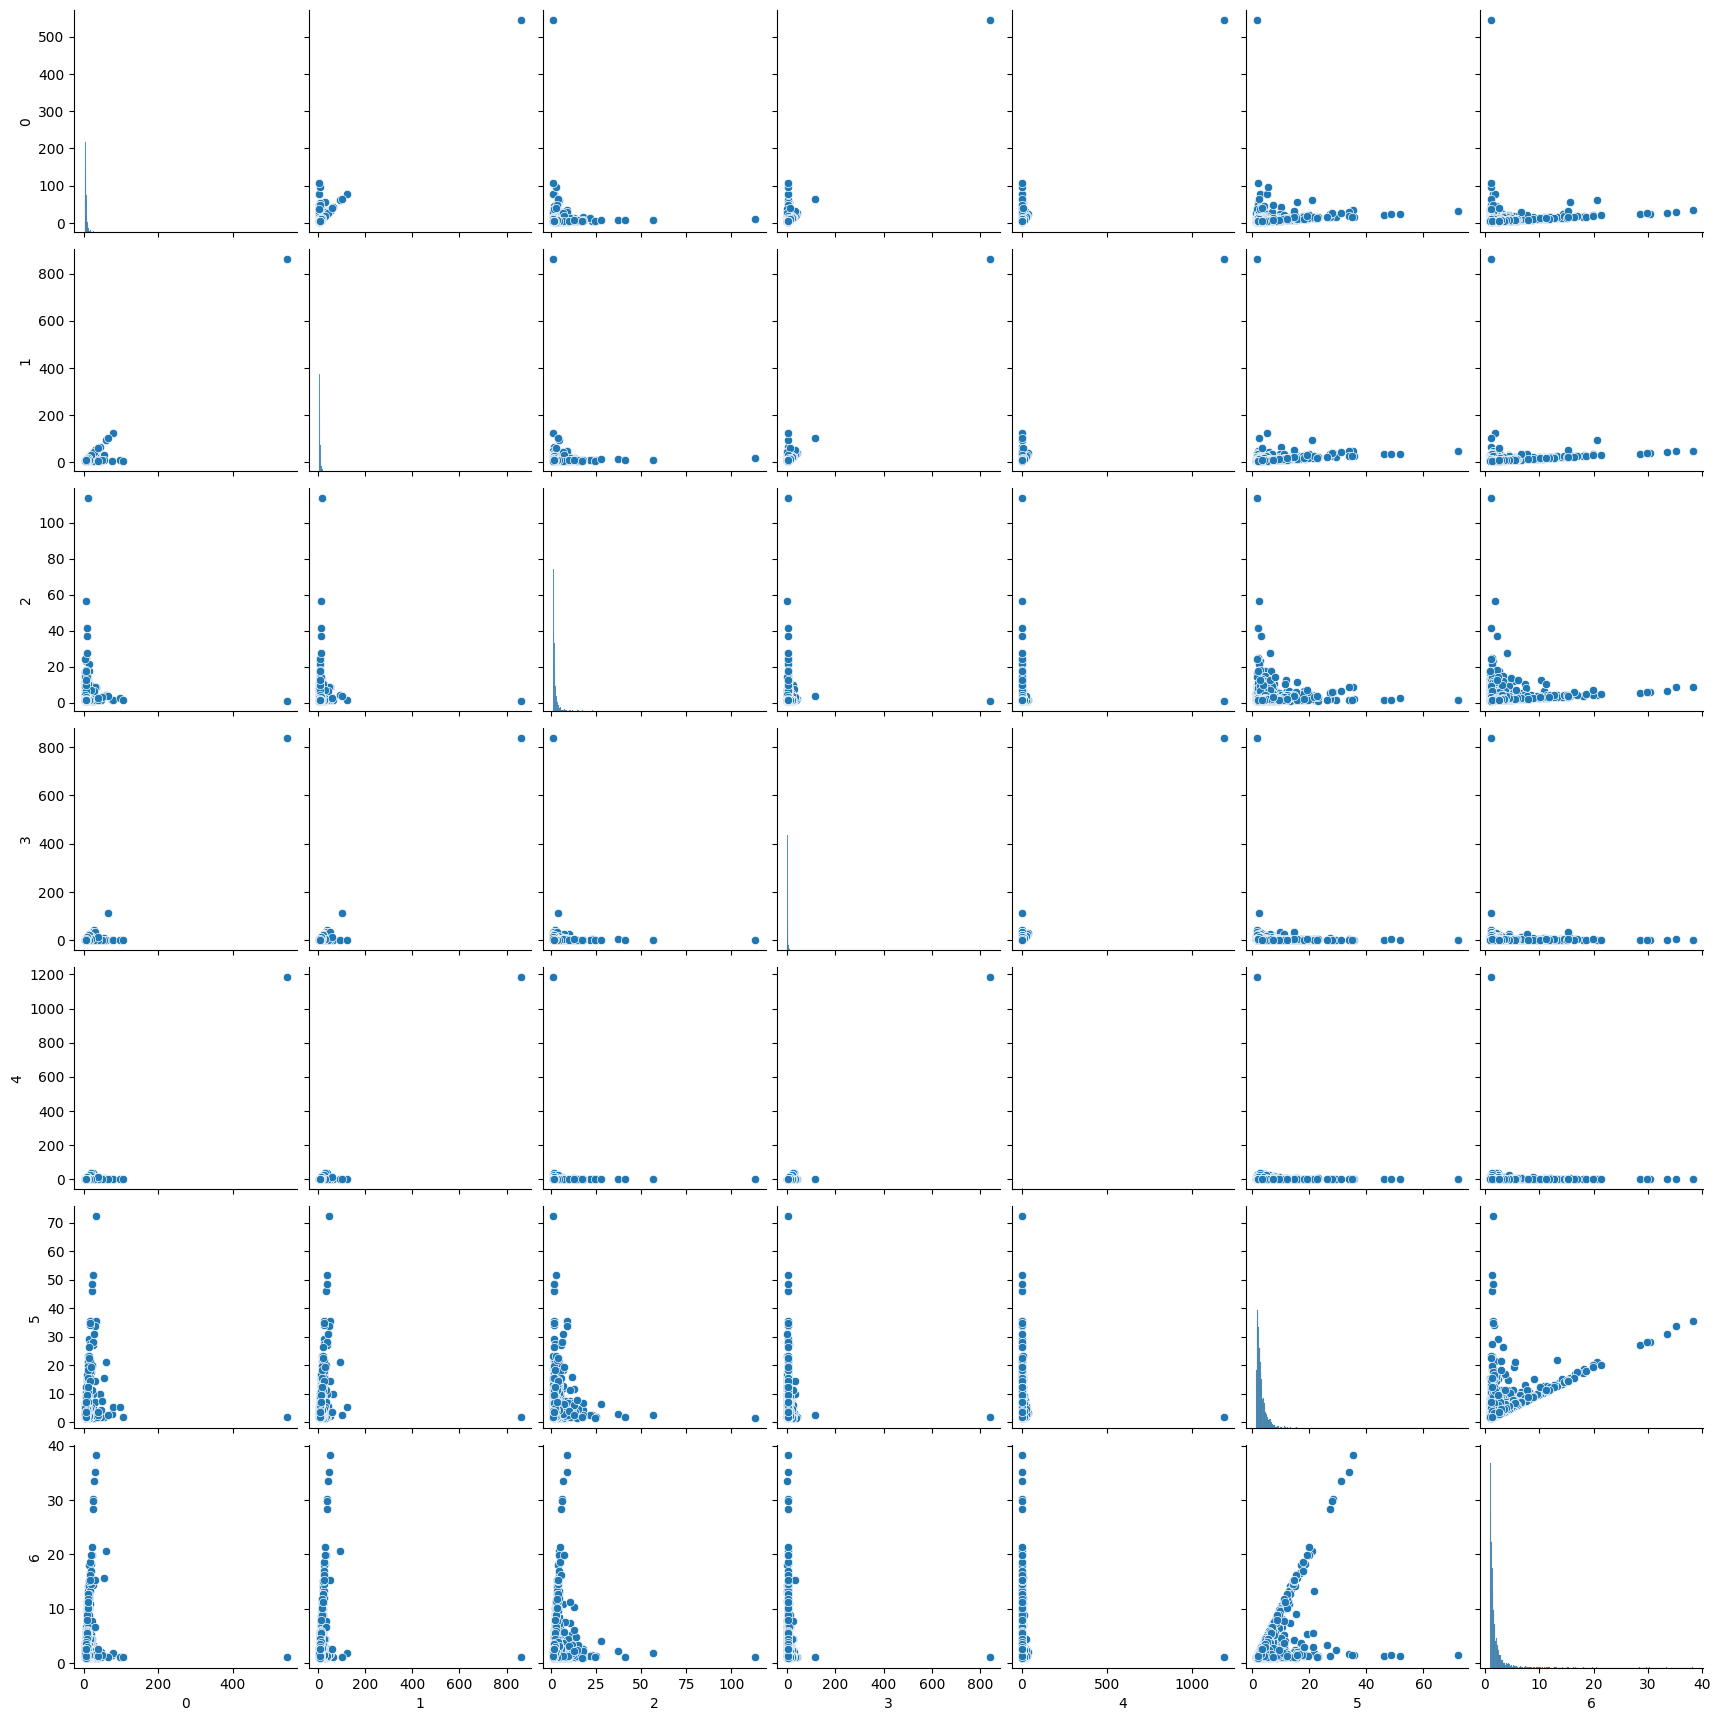

In [9]:
g=sns.pairplot(data_df,corner=False)

# Time series version

The path coefficient matrix $B$ is expanded with factor $\tau$: $B\in [0,1]^{(\tau+1) p\times (\tau+1) p}$ and extra constraint assumption $B_{ij}=B_{i+p,j+p}$ for $i,j=1,\dots,(\tau-1)p$ need to satisfy. 


We first do simulation and visualization

In [10]:
num_nodes = 5  # number of nodes
T=50000 # length of time series
sparsity_lag=0.15
sparsity_contemp=0.2
quantile=1 
burn_in=1000
pc_alpha=0.005
tau=2


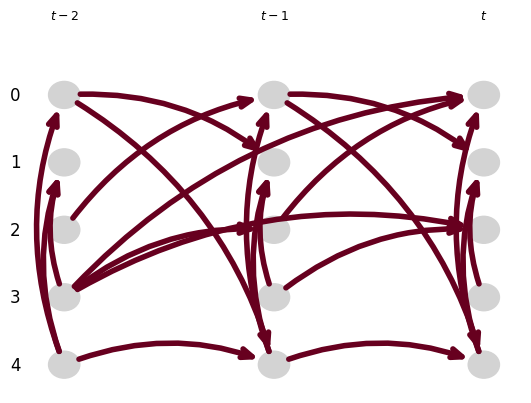

the spectral radius is 1.6861875810000246
the spectral radius is 0.7365573962630346


In [11]:

adjacency_matrix,true_graph=generate_dag_timeseries(num_nodes,sparsity_lag,sparsity_contemp,tau)
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)
spectral_radius=compute_spectral_radius(adjacency_matrix)
print(f"the spectral radius is {spectral_radius}")
if spectral_radius>1:
    adjacency_matrix=adjacency_matrix/(spectral_radius*1.1)
    spectral_radius=compute_spectral_radius(adjacency_matrix)
    print(f"the spectral radius is {spectral_radius}")

In [12]:
data_df=simulation_timeseries(T,burn_in,adjacency_matrix)

<AxesSubplot:>

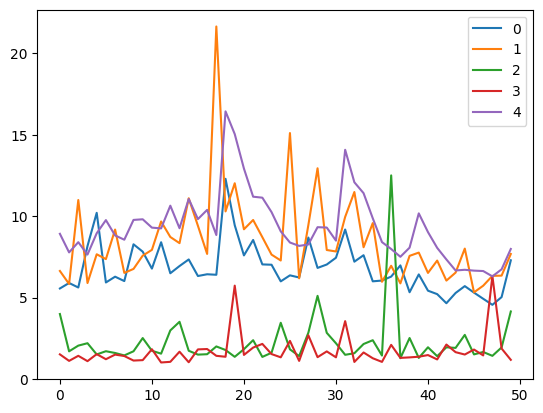

In [13]:
data_df.iloc[:50].plot()

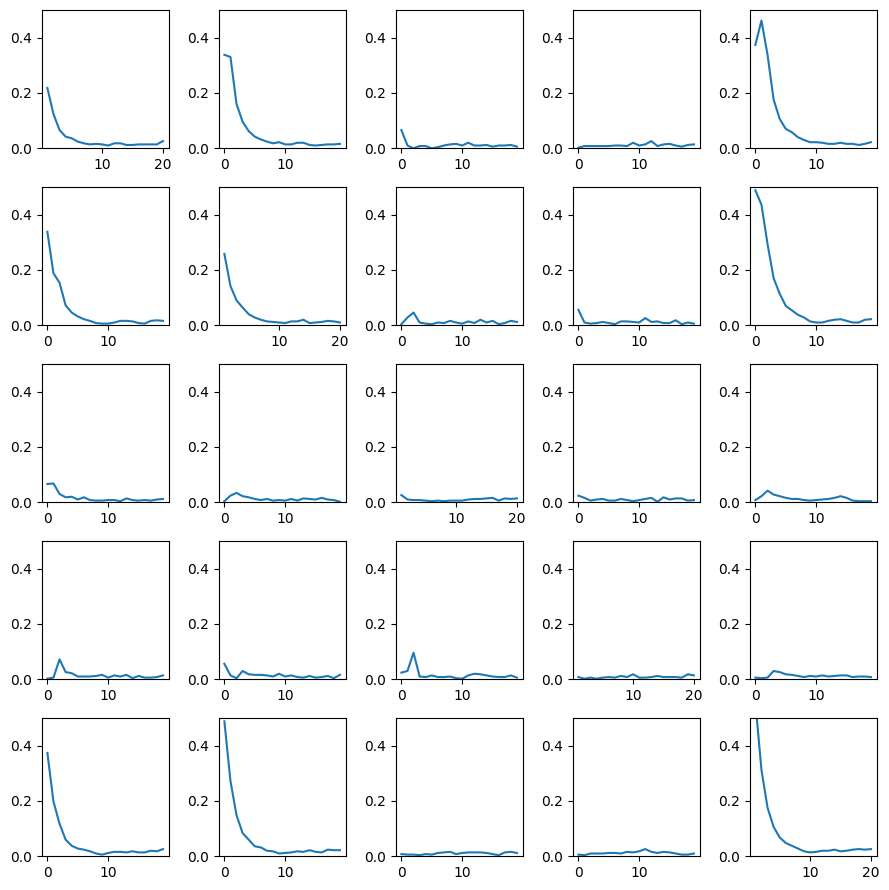

In [14]:

lagg=20
num_vars = data_df.shape[1]
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(9, 9))

for i in range(num_vars):
    for j in range(num_vars):
        if i==j:
            axes[i, j].plot(np.arange(1,lagg+1),extremeogram(data_df.values[:,[i,j]],maxlag=lagg+1)[1:])
        else:
            axes[i, j].plot(np.arange(lagg),extremeogram(data_df.values[:,[i,j]],maxlag=lagg))
        axes[i, j].set_ylim(0,0.5)



plt.tight_layout()
plt.show()

## then we do comparison with Bodik's method

In [17]:
num_nodes = 8  # number of nodes
T=5000 # length of time series
sparsity_lag=0.1
sparsity_contemp=0.3
quantile=1 
burn_in=1000
pc_alpha=0.005
tau=1


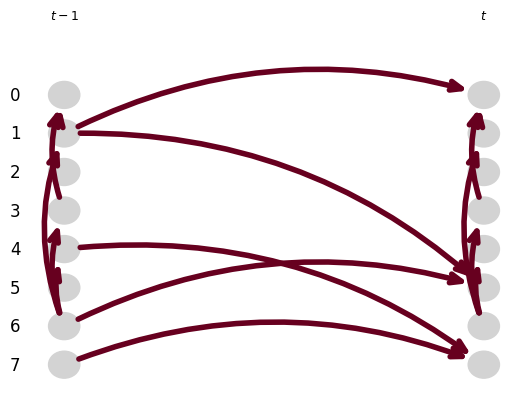

the spectral radius is 0.43170667633252213


<AxesSubplot:>

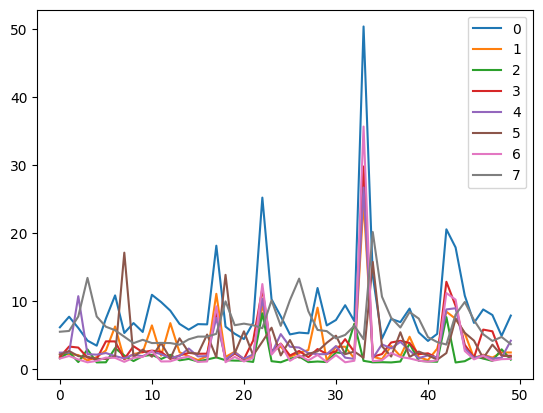

In [18]:

adjacency_matrix,true_graph=generate_dag_timeseries(num_nodes,sparsity_lag,sparsity_contemp,tau)
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)

spectral_radius=compute_spectral_radius(adjacency_matrix)
print(f"the spectral radius is {spectral_radius}")
if spectral_radius>1:
    adjacency_matrix=adjacency_matrix/(spectral_radius*1.1)
    spectral_radius=compute_spectral_radius(adjacency_matrix)
    print(f"the spectral radius is {spectral_radius}")
data_df=simulation_timeseries(T,burn_in,adjacency_matrix)
data_df.iloc[:50].plot()


In [19]:
resultsThisPaper,_=method_this_paper(data_df,tau_max=1,tau_min=0,quantile=quantile,pc_alpha=pc_alpha)
resultBodik=ComparisonBodik(data_df,1)


R[write to console]: 
Attaching package: ‘EnvStats’


R[write to console]: The following objects are masked from ‘package:stats’:

    predict, predict.lm




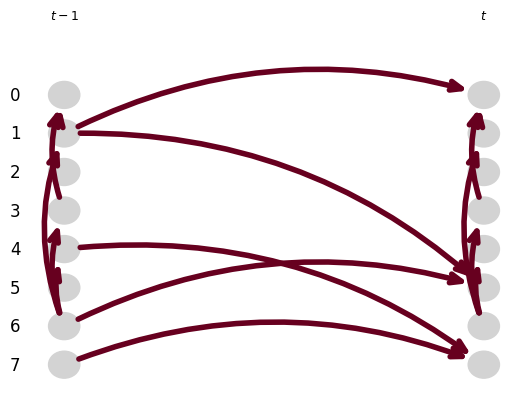

the results of this paper is: (with error rate: 33.3%)


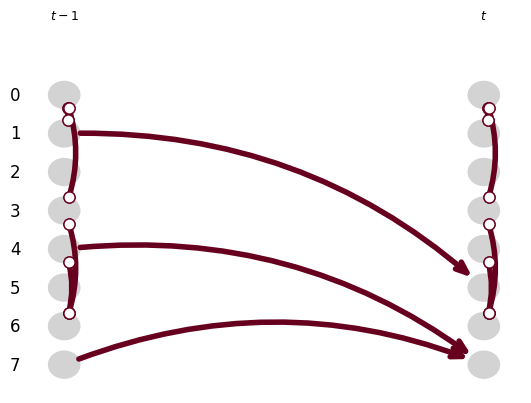

the results of bodik is: (with error rate: 53.8%)


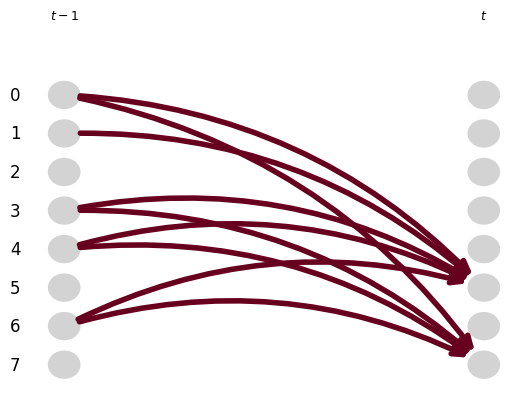

In [20]:
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)
error_rate_this_paper,error_edges_this_paper=compare_timeseries_graphs(resultsThisPaper,true_graph,exclude_contemp=True,exclude_self=True)
print(f"the results of this paper is: (with error rate: {error_rate_this_paper*100:.1f}%)")
draw_graph_timeseries(resultsThisPaper,vmin_edges=0,vmax_edges=1,show_colorbar=False)
error_rate_bodik,error_edges_bodik=compare_timeseries_graphs(resultBodik,true_graph,exclude_contemp=True,exclude_self=True)
print(f"the results of bodik is: (with error rate: {error_rate_bodik*100:.1f}%)")
draw_graph_timeseries(resultBodik,vmin_edges=0,vmax_edges=1,show_colorbar=False)
